<a href="https://colab.research.google.com/github/YarinBou/Deep-Neural-Networks-for-YouTube-Recommendations/blob/main/Deep_Neural_Networks_for_YouTube_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Neural Networks for YouTube Recommendations

**Prerequisites**

In [1]:
!pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

from sklearn.cluster import KMeans
from sklearn import preprocessing
from uszipcode import SearchEngine
import itertools as it
import math
from sklearn.model_selection import train_test_split

import tensorflow as tf
import os
from time import strftime
from sklearn.neighbors import KDTree
import io
from google.colab import drive
import pickle
from keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow import keras as k
from sklearn.model_selection import ParameterGrid


/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Mounting Drive**

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Set Random Seed**

In [6]:
random.seed(123)

## Data exploration 

Download the MovieLens 100K rating dataset.   

In [7]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [8]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

In [9]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users["user_id"] = df_users["user_id"].astype(int).apply(lambda x: x-1)
df_users.set_index('user_id', inplace=True)
df_users.head()

,age,gender,occupation,zip code
user_id,,,,
0,24,M,technician,85711
1,53,F,other,94043
2,23,M,writer,32067
3,24,M,technician,43537
4,33,F,other,15213


In [10]:
df_users.shape

(943, 4)

In [11]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items["movie id"] = df_items["movie id"].astype(int).apply(lambda x: int(x-1))
df_items["release_date"] = pd.to_datetime(df_items['release_date'], format='%d-%b-%Y')
df_items.drop(columns=['video_release_date', 'IMDb_URL'], inplace=True)
df_items.set_index('movie id', inplace=True)
df_items.head()

,movie_title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
0,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
df_items.shape

(1682, 21)

In [13]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings["user_id"] = df_ratings["user_id"].astype(int).apply(lambda x: x-1)
df_ratings["item_id"] = df_ratings["item_id"].astype(int).apply(lambda x: x-1)
df_ratings['rating'] = df_ratings['rating'].apply(float)
df_ratings['rating_binary'] = (df_ratings['rating'] >= df_ratings['rating'].mean()).astype(int)
df_ratings.head()

,user_id,item_id,rating,timestamp,rating_binary
0,195,241,3.0,881250949,0
1,185,301,3.0,891717742,0
2,21,376,1.0,878887116,0
3,243,50,2.0,880606923,0
4,165,345,1.0,886397596,0


In [14]:
df_ratings.shape

(100000, 5)

Making sure shapes are mathing the info data file

In [15]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

## Prepare Feature Data

In [16]:
def series_to_np(series):
    return np.array(list(series.values))

In [17]:
genres = [
    "unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film_Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci_Fi", "Thriller", "War", "Western",
]

# Convert genres to list of values
df_items['genres'] = df_items.apply(lambda x: [i for i, g in enumerate(genres) if x[g]], axis=1)
# movies_df.drop(columns=genres, inplace=True)
df_items.head()

,movie_title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,genres
movie id,,,,,,,,,,,,,,,,,,,,,
0,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,"[3, 4, 5]"
1,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[1, 2, 16]"
2,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,[16]
3,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 5, 8]"
4,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,"[6, 8, 16]"


In [18]:
# Normalize Discrete
occupations = list(df_users['occupation'].unique())
df_users['feat_occupation'] = df_users['occupation'].apply(lambda x: occupations.index(x))
user_occupation_oh = series_to_np(df_users['feat_occupation'].apply(lambda x: np.eye(len(occupations))[x]))
print(user_occupation_oh.shape)

genders = list(df_users['gender'].unique())
df_users['feat_gender'] = df_users['gender'].apply(lambda x: genders.index(x))
user_gender_oh = series_to_np(df_users['feat_gender'].apply(lambda x: np.eye(len(genders))[x]))
print(user_gender_oh.shape)

(943, 21)
(943, 2)


In [19]:
def set_zip_code_dict(x):
  zip_data = search.by_zipcode(x)
  if zip_data is None:
    return "Not a zip code"
  return zip_data.to_dict()


In [20]:
def set_lat_code_data(x):
  if type(x) is dict:
    return x['lat']
  if type(x) is str:
    return 37.41

In [21]:
def set_lng_code_data(x):
  if type(x) is dict:
    return x['lng']
  if type(x) is str:
    return -122.09


In [22]:
search = SearchEngine()
zipcode = search.by_zipcode("10001")
zipcode = zipcode.to_dict()
df_users['zip_code_dict'] = df_users['zip code'].apply(lambda x: set_zip_code_dict(x))
df_users['lat'] = df_users['zip_code_dict'].apply(lambda x: set_lat_code_data(x))
df_users['lng'] = df_users['zip_code_dict'].apply(lambda x: set_lng_code_data(x))

In [23]:
latlon = (df_users['zip code'].apply(lambda x: set_zip_code_dict(x))).apply(lambda x: [set_lat_code_data(x), set_lng_code_data(x)])
kmeans = KMeans(n_clusters=5, random_state=0).fit(np.array(list(latlon.values)))
df_users['feat_geo_area'] = kmeans.labels_
user_geo_oh = series_to_np(df_users['feat_geo_area'].apply(lambda x: np.eye(5)[x]))
print(user_geo_oh.shape)

(943, 5)


In [24]:
# Normalize ages
df_users['feat_age'] = preprocessing.StandardScaler().fit_transform(df_users['age'].values.reshape(-1, 1)).squeeze()
user_age = series_to_np(df_users['feat_age']).reshape((-1, 1))
print(user_age.shape)

(943, 1)


In [25]:
# Extract Example Age
df_items.rename(columns = {'movie id':'item_id'}, inplace = True)
df_ratings_tmp = df_ratings.join(df_items, on='item_id')
print(df_ratings_tmp.columns)
sum = 0 


df_ratings['example_age'] = (pd.to_datetime(df_ratings_tmp['timestamp']) - df_ratings_tmp['release_date']).apply(lambda x: float(x.days))
df_ratings['example_age'] = df_ratings['example_age'].fillna(df_ratings['example_age'].mean())
df_ratings['example_age'] = preprocessing.StandardScaler().fit_transform(df_ratings['example_age'].values.reshape(-1, 1)).squeeze()
df_ratings

Index(['user_id', 'item_id', 'rating', 'timestamp', 'rating_binary',
       'movie_title', 'release_date', 'unknown', 'Action', 'Adventure',
       'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'War', 'Western', 'genres'],
      dtype='object')


,user_id,item_id,rating,timestamp,rating_binary,example_age
0,195,241,3.0,881250949,0,-0.628909
1,185,301,3.0,891717742,0,-0.624488
2,21,376,1.0,878887116,0,-0.413825
3,243,50,2.0,880606923,0,-0.413825
4,165,345,1.0,886397596,0,-0.624488
...,...,...,...,...,...,...
99995,879,475,3.0,880175444,0,-0.603537
99996,715,203,5.0,879795543,1,0.217973
99997,275,1089,1.0,874795795,0,-0.343668
99998,12,224,2.0,882399156,0,-0.617761


In [26]:
# Create User Feature Vector
df_users['feat_vec'] = list(np.hstack([user_occupation_oh, user_gender_oh, user_geo_oh, user_age]))

## Prepare Watch History Data
We use next watch prediction instead of held out watch prediction

In [27]:
user_ratings_grouped = (df_ratings
    .join(df_items[['genres']], on='item_id', how='inner')
    .sort_values(by='timestamp')
    .groupby(['user_id'])
    .agg({'item_id': list, 'timestamp': list, 'rating_binary': list, 'genres': list, 'example_age': list})
)
user_ratings_grouped.head()

,item_id,timestamp,rating_binary,genres,example_age
user_id,,,,,
0,"[167, 171, 164, 155, 165, 195, 186, 249, 13, 1...","[874965478, 874965478, 874965518, 874965556, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[[5], [1, 2, 8, 14, 15, 17], [8], [6, 16], [8]...","[0.9902771506537741, 0.5691427162353065, 0.147..."
1,"[285, 257, 304, 306, 287, 311, 300, 268, 291, ...","[888549960, 888549961, 888550065, 888550066, 8...","[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...","[[8, 14, 17], [8, 15], [8], [6, 11, 13, 16], [...","[-0.6154540520536095, -0.6612002845463504, -0...."
2,"[299, 343, 332, 301, 267, 302, 336, 344, 353, ...","[889236939, 889236939, 889236939, 889236939, 8...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 16], [8], [13, 16], [6, 10, 13, 16], [8, ...","[-0.6244879719156213, -0.6919540542893694, -0...."
3,"[257, 287, 299, 327, 270, 361, 358, 328, 326, ...","[892001374, 892001445, 892001445, 892001537, 8...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[8, 15], [11, 16], [1, 16], [1, 13, 14, 16], ...","[-0.6612002845463504, -0.6221814391848949, -0...."
4,"[266, 221, 454, 120, 362, 404, 256, 249, 24, 2...","[875635064, 875635174, 875635174, 875635189, 8...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...","[[0], [1, 2, 15], [1], [1, 15, 17], [1], [1, 2...","[0.0, -0.6167995294798666, -0.6262178714636661..."


In [28]:
# Split user history using windows
WINDOW_SIZE = 16

def extract_windows(user_id, item):
    for j in range(len(item['item_id']) - (WINDOW_SIZE + 1)):
        # Use only positives for labels. Is it excessive though
#         if item.rating_binary[j + WINDOW_SIZE] != 1: continue
            
        movie_ids = item['item_id'][j:j+WINDOW_SIZE]
        ratings = item['rating_binary'][j:j+WINDOW_SIZE]
        genres = list(set(it.chain(*item['genres'][j:j+WINDOW_SIZE])))
        positives = list(np.array(movie_ids)[np.array(ratings, dtype=bool)])
        negatives = list(np.array(movie_ids)[~np.array(ratings, dtype=bool)])
        next_id = item['item_id'][j + WINDOW_SIZE]
        next_label = item['rating_binary'][j+WINDOW_SIZE]
        example_age = item['example_age'][j + WINDOW_SIZE]
        
        
        yield (
            user_id, movie_ids, ratings, genres,
            positives, negatives, next_id, next_label, example_age
        )
    
windows_df = pd.DataFrame(
    it.chain(*it.starmap(extract_windows, user_ratings_grouped.iterrows())), 
    columns=['user_id', 'movie_ids', 'ratings', 'genres', 'positives', 'negatives', 'next', 'next_label', 'example_age']
)
windows_df.head()

,user_id,movie_ids,ratings,genres,positives,negatives,next,next_label,example_age
0,0,"[167, 171, 164, 155, 165, 195, 186, 249, 13, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]","[167, 171, 164, 155, 165, 195, 186, 249, 13, 1...",[116],256,1,-0.659855
1,0,"[171, 164, 155, 165, 195, 186, 249, 13, 126, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]","[171, 164, 155, 165, 195, 186, 249, 13, 126, 1...",[116],49,1,0.779614
2,0,"[164, 155, 165, 195, 186, 249, 13, 126, 180, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]","[164, 155, 165, 195, 186, 249, 13, 126, 180, 1...",[116],248,1,-0.647746
3,0,"[155, 165, 195, 186, 249, 13, 126, 180, 116, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]","[155, 165, 195, 186, 249, 13, 126, 180, 108, 0...",[116],252,1,-0.655818
4,0,"[165, 195, 186, 249, 13, 126, 180, 116, 108, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]","[165, 195, 186, 249, 13, 126, 180, 108, 0, 245...",[116],261,0,-0.665237


In [29]:
examples_unbalanced_df = (windows_df[['user_id', 'positives', 'negatives', 'genres', 'next', 'next_label', 'example_age']]
       .join(df_users['feat_vec'], on='user_id')
       .rename(columns={'genres': 'search', 'next': 'label', 'feat_vec': 'user_data'})
)
examples_unbalanced_df.head()

,user_id,positives,negatives,search,label,next_label,example_age,user_data
0,0,"[167, 171, 164, 155, 165, 195, 186, 249, 13, 1...",[116],"[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]",256,1,-0.659855,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,"[171, 164, 155, 165, 195, 186, 249, 13, 126, 1...",[116],"[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]",49,1,0.779614,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,"[164, 155, 165, 195, 186, 249, 13, 126, 180, 1...",[116],"[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]",248,1,-0.647746,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,"[155, 165, 195, 186, 249, 13, 126, 180, 108, 0...",[116],"[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]",252,1,-0.655818,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,"[165, 195, 186, 249, 13, 126, 180, 108, 0, 245...",[116],"[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 17]",261,0,-0.665237,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
def balance(df, key, replace=False):
    print(df.groupby(key).size().describe())
    n_examples = math.ceil(df.groupby(key).size().mean())
    print(f'Using {n_examples} examples per {key}')
    balanced_df = df.groupby(key)\
        .apply(lambda x: x.sample(min(n_examples, len(x) if not replace else n_examples), replace=replace)) \
        .reset_index(drop=True)
    print(balanced_df.groupby(key).size().describe())
    return balanced_df

# Balance training data by limiting amount of examples per user
examples_df = balance(examples_unbalanced_df, 'user_id', False)

# Balance training data by limiting amount of examples per label
examples_df = balance(examples_df, 'label', True)

count    943.000000
mean      89.044539
std      100.931743
min        3.000000
25%       16.000000
50%       48.000000
75%      131.000000
max      720.000000
dtype: float64
Using 90 examples per user_id
count    943.000000
mean      51.218452
std       34.681459
min        3.000000
25%       16.000000
50%       48.000000
75%       90.000000
max       90.000000
dtype: float64
count    1542.000000
mean       31.322309
std        40.838763
min         1.000000
25%         4.000000
50%        15.000000
75%        41.750000
max       270.000000
dtype: float64
Using 32 examples per label
count    1542.0
mean       32.0
std         0.0
min        32.0
25%        32.0
50%        32.0
75%        32.0
max        32.0
dtype: float64


## Build the Candidate Generation Model


In [31]:
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        # masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        masked_embeddings = inputs
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [32]:
def CandidateGeneration(n_items, n_search_items, n_user_data, embedding_dim, user_dim):
    # Define layers
    search_ids_input = k.Input(shape=(None, ), name='search_ids')
    positive_ids_input = k.Input(shape=(None, ), name='positive_ids')
    negative_ids_input = k.Input(shape=(None, ), name='negative_ids')
    user_data_input = k.Input(shape=(n_user_data), name='user_data_vec')

    search_embedding_layer = k.layers.Embedding(input_dim=n_search_items, output_dim=EMBEDDING_DIMS, 
                                                mask_zero=True, trainable=True, name='search_embeddings')
    labels_embedding_layer = k.layers.Embedding(input_dim=n_items, output_dim=EMBEDDING_DIMS,
                                                mask_zero=True, trainable=True, name='labels_embeddings')
    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    dense_1 = k.layers.Dense(units=DENSE_UNITS, name='dense_1')
    dense_2 = k.layers.Dense(units=DENSE_UNITS, name='dense_2')
    dense_3 = k.layers.Dense(units=user_dim, name='dense_3')

    l2_norm_1 = L2NormLayer(name='l2_norm_1')
    dense_output = k.layers.Dense(n_items, activation=tf.nn.softmax, name='dense_output')
    
    # Feature extraction
    search_embeddings = search_embedding_layer(search_ids_input)
    l2_norm_search = l2_norm_1(search_embeddings)
    avg_search = avg_embeddings(l2_norm_search)
    
    labels_positive_embeddings = labels_embedding_layer(positive_ids_input)
    l2_norm_positive = l2_norm_1(labels_positive_embeddings)
    avg_positive = avg_embeddings(l2_norm_positive)
    
    labels_negative_embeddings = labels_embedding_layer(negative_ids_input)
    l2_norm_negative = l2_norm_1(labels_negative_embeddings)
    avg_negative = avg_embeddings(l2_norm_negative)
    
    concat_inputs = tf.keras.layers.Concatenate(axis=1)([
        avg_search, avg_positive, avg_negative, user_data_input
    ])
    
    # Dense Layers
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    dense_2_features = dense_2(dense_1_batch_norm)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    dense_3_features = dense_3(dense_2_batch_norm)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='user_vec')(dense_3_relu)
    outputs = dense_output(dense_3_batch_norm)
    
    model = tf.keras.models.Model(
        inputs=[search_ids_input, positive_ids_input, negative_ids_input, user_data_input],
        outputs=[outputs]
    )
    
    return model

In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras as k
from sklearn.model_selection import ParameterGrid

train_val_df, test_df = train_test_split(examples_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [34]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
USER_DIM=32
LEARNING_RATE = 0.003

# Compile Model
model = CandidateGeneration(
    n_items=df_items.index.astype(int).max()+2, 
    n_search_items=len(genres) + 1, 
    n_user_data=len(examples_df.iloc[0]['user_data']), 
    embedding_dim=EMBEDDING_DIMS,
    user_dim=USER_DIM
)
optimiser = k.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modified_model = k.Model(inputs=model.input, outputs=[model.get_layer('user_vec').output, *model.outputs])

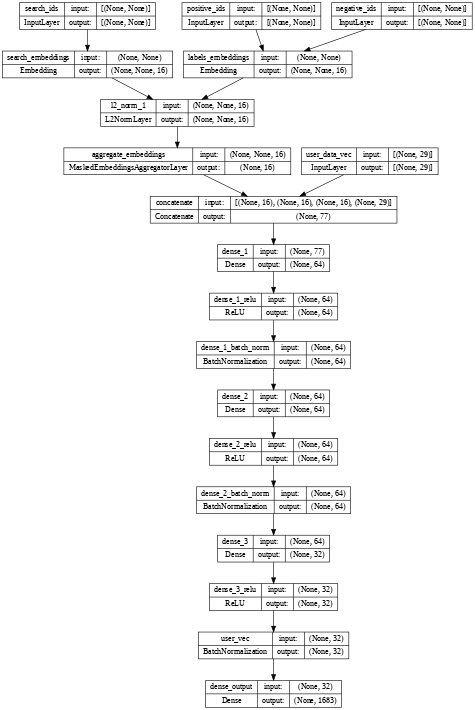

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=42)

## Train the model


In [36]:
"""candidate_history = model.fit(
    x=[
        k.preprocessing.sequence.pad_sequences(train_df['search']),
        k.preprocessing.sequence.pad_sequences(train_df['positives']),
        k.preprocessing.sequence.pad_sequences(train_df['negatives']),
        k.preprocessing.sequence.pad_sequences(train_df['user_data'])
    ], 
    y=train_df['label'].values,
    validation_data=([
        k.preprocessing.sequence.pad_sequences(val_df['search']),
        k.preprocessing.sequence.pad_sequences(val_df['positives']),
        k.preprocessing.sequence.pad_sequences(val_df['negatives']),
        k.preprocessing.sequence.pad_sequences(val_df['user_data'])
    ], val_df['label'].values),
    callbacks=[
        k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
        k.callbacks.EarlyStopping(patience=800, restore_best_weights=True)
    ], 
    steps_per_epoch=3, 
    epochs=1600, 
    verbose=1,
)
"""

'candidate_history = model.fit(\n    x=[\n        k.preprocessing.sequence.pad_sequences(train_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(train_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(train_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(train_df[\'user_data\'])\n    ], \n    y=train_df[\'label\'].values,\n    validation_data=([\n        k.preprocessing.sequence.pad_sequences(val_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(val_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(val_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(val_df[\'user_data\'])\n    ], val_df[\'label\'].values),\n    callbacks=[\n        k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),\n        k.callbacks.EarlyStopping(patience=800, restore_best_weights=True)\n    ], \n    steps_per_epoch=3, \n    epochs=1600, \n    verbose=1,\n)\n'

In [37]:
"""
model.save('model.h5')
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/candidate_history.pickle', 'wb') as f:
    pickle.dump(candidate_history.history, f)
"""

"\nmodel.save('model.h5')\nwith open('/content/drive/MyDrive/Colab_Notebooks/recsys/candidate_history.pickle', 'wb') as f:\n    pickle.dump(candidate_history.history, f)\n"

## Load the model

In [38]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [39]:
%cd /content/drive/MyDrive/Colab_Notebooks/recsys

/content/drive/MyDrive/Colab_Notebooks/recsys


In [40]:
!cp model.h5 /content/drive/MyDrive/Colab_Notebooks/recsys

cp: 'model.h5' and '/content/drive/MyDrive/Colab_Notebooks/recsys/model.h5' are the same file


In [41]:
model = load_model('/content/drive/MyDrive/Colab_Notebooks/recsys/model.h5', custom_objects={'L2NormLayer': L2NormLayer,'MaskedEmbeddingsAggregatorLayer':MaskedEmbeddingsAggregatorLayer})
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/candidate_history.pickle', 'rb') as f:
    candidate_history = pickle.load(f)

In [42]:
modified_model = k.Model(inputs=model.input, outputs=[model.get_layer('user_vec').output, *model.outputs])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 search_ids (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 positive_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 negative_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 search_embeddings (Embedding)  (None, None, 16)     320         ['search_ids[0][0]']             
                                                                                              

In [44]:
modified_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 search_ids (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 positive_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 negative_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 search_embeddings (Embedding)  (None, None, 16)     320         ['search_ids[0][0]']             
                                                                                            

In [45]:
movie_embeddings = model.get_layer('labels_embeddings').get_weights()[0][1:]

# Export Embeddings
titles = list(df_items['movie_title'])

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
        for i, title in enumerate(df_items['movie_title']):
          out_m.write(title + "\n")
          out_v.write('\t'.join([str(x) for x in movie_embeddings[i]]) + "\n")

movie_embeddings.shape

(1682, 16)

## Visualize candidate_history

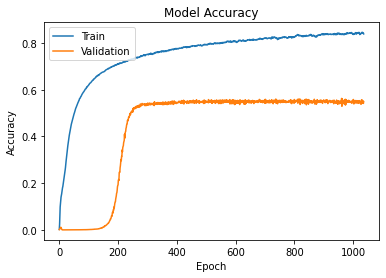

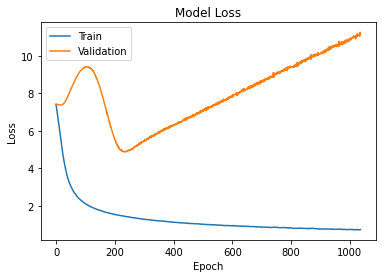

In [46]:
# Plot training and validation accuracy values
plt.plot(candidate_history['accuracy'])
plt.plot(candidate_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(candidate_history['loss'])
plt.plot(candidate_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Genarate Candidates 

In [47]:
examples_df.shape

(49344, 8)

In [48]:
sample_df = examples_df.sample(48896)
user_vecs, movie_vecs = modified_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_df['search']),
        k.preprocessing.sequence.pad_sequences(sample_df['positives']),
        k.preprocessing.sequence.pad_sequences(sample_df['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_df['user_data'])
])
user_vecs.shape

1528/1528 [==============================] - 8s 5ms/step


(48896, 32)

In [49]:
top_k = 10
movie_vecs = np.array([movie_vecs[i, :].argsort()[-top_k:] for i in range(len(movie_vecs))]) - 1
movie_vecs.shape

(48896, 10)

In [50]:
kdt = KDTree(user_vecs, metric='euclidean')

In [51]:
sample_user_df = examples_df.sample(1)
ex_user_vecs, _ = modified_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_user_df['search']),
        k.preprocessing.sequence.pad_sequences(sample_user_df['positives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df['user_data'])
])
ex_dist, ex_movie_vec_ids = kdt.query(ex_user_vecs,6)
candidates = set(filter(lambda x: x > 0, movie_vecs[ex_movie_vec_ids.squeeze()].flatten()))
candidates_df = df_items.iloc[list(candidates)]
candidates_df

1/1 [==============================] - 0s 196ms/step


,movie_title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,genres
movie id,,,,,,,,,,,,,,,,,,,,,
896,Time Tracers (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[1, 2, 15]"
770,Johnny Mnemonic (1995),1995-01-01,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,"[1, 15, 16]"
644,Paris Is Burning (1990),1990-01-01,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,[7]
1159,Love! Valour! Compassion! (1997),1997-05-16,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"[8, 14]"
647,"Quiet Man, The (1952)",1952-01-01,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,"[5, 14]"
519,"Great Escape, The (1963)",1963-01-01,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[2, 17]"
521,Down by Law (1986),1986-01-01,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[5, 8]"
142,"Sound of Music, The (1965)",1965-01-01,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,[12]
271,Good Will Hunting (1997),1997-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[8]


In [52]:
unique_ids = examples_df['user_id'].unique().tolist()

In [53]:
candidates_dict = {}
for user_id in unique_ids:
  user_df = examples_df.loc[examples_df['user_id'] == user_id]
  ex_user_vecs, _ = modified_model.predict(x=[
          k.preprocessing.sequence.pad_sequences(user_df['search']),
          k.preprocessing.sequence.pad_sequences(user_df['positives']),
          k.preprocessing.sequence.pad_sequences(user_df['negatives']),
          k.preprocessing.sequence.pad_sequences(user_df['user_data'])
])
  if np.isnan(ex_user_vecs).any() or np.isinf(ex_user_vecs).any():
      # Handle NaN, infinite or too large values in ex_user_vecs
      # You can choose to skip this user or replace NaN/infinite values with a default value
      continue
  ex_dist, ex_movie_vec_ids = kdt.query(ex_user_vecs,6)
  candidates = set(filter(lambda x: x > 0, movie_vecs[ex_movie_vec_ids.squeeze()].flatten()))
  candidates_dict[user_id] = candidates



1/1 [==============================] - 0s 36ms/step


In [54]:
# function to update candidates column based on user_id
def update_candidates(row):
    user_id = row["user_id"]
    if user_id in candidates_dict:
        candidates = candidates_dict[user_id]
        return list(candidates)
    else:
        return ""

## Ranking Stage

In [55]:
example_ranking_df = examples_df.copy()
example_ranking_df.insert(1, 'candidates', None)
example_ranking_df['candidates'] = np.empty((len(example_ranking_df), 0)).tolist()
# apply function to update candidates column
example_ranking_df["candidates"] = example_ranking_df.apply(update_candidates, axis=1)

In [56]:
example_ranking_df[['user_id']].value_counts()

user_id
781        611
404        541
180        418
278        327
166        313
          ... 
368          1
440          1
162          1
50           1
635          1
Length: 934, dtype: int64

In [57]:
def Ranking(n_items, n_genres, n_user_data, embedding_dim, user_dim):
    # Define layers
    genres_ids_input = k.Input(shape=(None, ), name='genres_ids')
    candidates_ids_input = k.Input(shape=(None, ), name='candidates_ids')
    positive_ids_input = k.Input(shape=(None, ), name='positive_ids')
    negative_ids_input = k.Input(shape=(None, ), name='negative_ids')
    user_data_input = k.Input(shape=(n_user_data), name='user_data_vec')

    genres_embedding_layer = k.layers.Embedding(input_dim=n_genres, output_dim=EMBEDDING_DIMS, 
                                                mask_zero=True, trainable=True, name='genres_embeddings')
    labels_embedding_layer = k.layers.Embedding(input_dim=n_items, output_dim=EMBEDDING_DIMS,
                                                mask_zero=True, trainable=True, name='labels_embeddings')
    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    dense_1 = k.layers.Dense(units=DENSE_UNITS, name='dense_1')
    dense_2 = k.layers.Dense(units=DENSE_UNITS, name='dense_2')
    dense_3 = k.layers.Dense(units=user_dim, name='dense_3')

    l2_norm_1 = L2NormLayer(name='l2_norm_1')
    dense_output = k.layers.Dense(n_items, activation=tf.nn.softmax, name='dense_output')
    
    # Feature extraction
    genres_embeddings = genres_embedding_layer(genres_ids_input)
    l2_norm_genres= l2_norm_1(genres_embeddings)
    avg_genres = avg_embeddings(l2_norm_genres)
    
    labels_candidates_embeddings = labels_embedding_layer(candidates_ids_input)
    l2_norm_candidates = l2_norm_1(labels_candidates_embeddings)
    avg_candidates = avg_embeddings(l2_norm_candidates)

    labels_positive_embeddings = labels_embedding_layer(positive_ids_input)
    l2_norm_positive = l2_norm_1(labels_positive_embeddings)
    avg_positive = avg_embeddings(l2_norm_positive)
    
    labels_negative_embeddings = labels_embedding_layer(negative_ids_input)
    l2_norm_negative = l2_norm_1(labels_negative_embeddings)
    avg_negative = avg_embeddings(l2_norm_negative)
    
    concat_inputs = tf.keras.layers.Concatenate(axis=1)([
        avg_genres, avg_positive, avg_negative, user_data_input,avg_candidates
    ])
    
    # Dense Layers
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    dense_2_features = dense_2(dense_1_batch_norm)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    dense_3_features = dense_3(dense_2_batch_norm)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='user_vec')(dense_3_relu)
    outputs = dense_output(dense_3_batch_norm)
    
    model = tf.keras.models.Model(
        inputs=[genres_ids_input,candidates_ids_input, positive_ids_input, negative_ids_input, user_data_input],
        outputs=[outputs]
    )
    
    return model

In [58]:
train_val_df, test_df = train_test_split(examples_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [59]:
#Important notice: Since the training time took in total ~75 hours and colab disconnect every 12 or 24 hours, we divide the traning into separate running,
#We save each of the traning parts into a CSV file and then merge them.
# those are the parmas that been tested:
EMBEDDING_DIMS_LIST = [16, 32, 64, 1024]
LEARNING_RATE_LIST = [0.0001 ,0.0003, 0.001, 0.003]
DENSE_UNITS_LIST = [32, 64,128]
USER_DIM_LIST = [32, 64,128]
EPOCHE_LIST = [10,150,250]

In [60]:
def find_best_params_ranking(EMBEDDING_DIMS_LIST, LEARNING_RATE_LIST, DENSE_UNITS_LIST, USER_DIM_LIST, EPOCHE_LIST):
    # Define constants
    BATCH_SIZE = 256
    
    # Create parameter grid
    param_grid = ParameterGrid({
        'EMBEDDING_DIMS': EMBEDDING_DIMS_LIST,
        'LEARNING_RATE': LEARNING_RATE_LIST,
        'DENSE_UNITS': DENSE_UNITS_LIST,
        'USER_DIM': USER_DIM_LIST,
        'EPOCHS': EPOCHE_LIST
    })
    
    # Train model for each combination of parameters
    results = []
    for params in param_grid:
        # Compile Model
        ranking_model = Ranking(
            n_items=df_items.index.astype(int).max()+2, 
            n_genres=len(genres) + 1, 
            n_user_data=len(examples_df.iloc[0]['user_data']), 
            embedding_dim=params['EMBEDDING_DIMS'],
            user_dim=params['USER_DIM']
        )
        optimiser = k.optimizers.Adam(learning_rate=params['LEARNING_RATE'])
        ranking_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train model
        history = ranking_with_attention_model.fit(
            x=[
              k.preprocessing.sequence.pad_sequences(train_df['search']),
              k.preprocessing.sequence.pad_sequences(train_df['candidates']),
              k.preprocessing.sequence.pad_sequences(train_df['positives']),
              k.preprocessing.sequence.pad_sequences(train_df['negatives']),
              k.preprocessing.sequence.pad_sequences(train_df['user_data']),
               ], 
            y=train_df['label'].values, 
            batch_size=BATCH_SIZE, 
            epochs=params['EPOCHS'], 
            validation_data=([
                k.preprocessing.sequence.pad_sequences(val_df['search']),
                k.preprocessing.sequence.pad_sequences(val_df['candidates']),
                k.preprocessing.sequence.pad_sequences(val_df['positives']),
                k.preprocessing.sequence.pad_sequences(val_df['negatives']),
                k.preprocessing.sequence.pad_sequences(val_df['user_data']),
            ], val_df['label'].values),
            verbose=1
        )
        
        # Evaluate model
        loss, accuracy = ranking_with_attention_model.evaluate([
                k.preprocessing.sequence.pad_sequences(test_df['search']),
                k.preprocessing.sequence.pad_sequences(test_df['candidates']),
                k.preprocessing.sequence.pad_sequences(test_df['positives']),
                k.preprocessing.sequence.pad_sequences(test_df['negatives']),
                k.preprocessing.sequence.pad_sequences(test_df['user_data']),
            ], test_df['label'].values,
            batch_size=BATCH_SIZE, 
            verbose=1
        )
        
        # Save results
        results.append({
            'EMBEDDING_DIMS': params['EMBEDDING_DIMS'],
            'LEARNING_RATE': params['LEARNING_RATE'],
            'DENSE_UNITS': params['DENSE_UNITS'],
            'USER_DIM': params['USER_DIM'],
            'EPOCHS': params['EPOCHS'],
            'loss': loss,
            'accuracy': accuracy,
            'history': history
        })
        
        # Print progress
        print(f"Finished training model with params: {params}")
        
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Return DataFrame sorted by accuracy
    return results_df.sort_values(by='accuracy', ascending=False)


In [61]:
# results_ranking_df = find_best_params_ranking(EMBEDDING_DIMS_LIST, LEARNING_RATE_LIST, DENSE_UNITS_LIST, USER_DIM_LIST, EPOCHE_LIST)

In [62]:
results_ranking_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recsys/params_result_for_paper_alg.csv')

In [ ]:
results_ranking_df

In [63]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
USER_DIM=32
LEARNING_RATE = 0.003

# Compile Model
ranking_model = Ranking(
    n_items=df_items.index.astype(int).max()+2, 
    n_genres=len(genres) + 1, 
    n_user_data=len(examples_df.iloc[0]['user_data']), 
    embedding_dim=EMBEDDING_DIMS,
    user_dim=USER_DIM
)
optimiser = k.optimizers.Adam(learning_rate=LEARNING_RATE)
ranking_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modified_model = k.Model(inputs=ranking_model.input, outputs=[ranking_model.get_layer('user_vec').output, *ranking_model.outputs])

In [64]:
"""
ranking_history = ranking_model.fit(
    x=[
        k.preprocessing.sequence.pad_sequences(rank_train_df['search']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['candidates']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['positives']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['negatives']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['user_data']),
    ], 
    y=rank_train_df['label'].values,
    validation_data=([
        k.preprocessing.sequence.pad_sequences(rank_val_df['search']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['candidates']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['positives']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['negatives']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['user_data']),
    ], rank_val_df['label'].values),
    callbacks=[
        k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
        k.callbacks.EarlyStopping(patience=800, restore_best_weights=True)
    ], 
    steps_per_epoch=3, 
    epochs=1600, 
    verbose=1,
)
"""

'\nranking_history = ranking_model.fit(\n    x=[\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'candidates\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'user_data\']),\n    ], \n    y=rank_train_df[\'label\'].values,\n    validation_data=([\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'candidates\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'user_data\']),\n    ], rank_val_df[\'label\'].values),\n    callbacks=[\n        k.callbacks.TensorBoard(os.path.join

In [65]:
ranking_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 genres_ids (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 positive_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 negative_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 candidates_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                            

In [66]:
"""
ranking_model.save('ranking_model.h5')
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_history.pickle', 'wb') as f:
    pickle.dump(ranking_history.history, f)
"""

"\nranking_model.save('ranking_model.h5')\nwith open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_history.pickle', 'wb') as f:\n    pickle.dump(ranking_history.history, f)\n"

In [67]:
ranking_model = load_model('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_model.h5', custom_objects={'L2NormLayer': L2NormLayer,'MaskedEmbeddingsAggregatorLayer':MaskedEmbeddingsAggregatorLayer})
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_history.pickle', 'rb') as f:
    ranking_history = pickle.load(f)

In [68]:
modified_ranking_model = k.Model(inputs=ranking_model.input, outputs=[ranking_model.get_layer('user_vec').output, *ranking_model.outputs])

## Visualize ranking_history

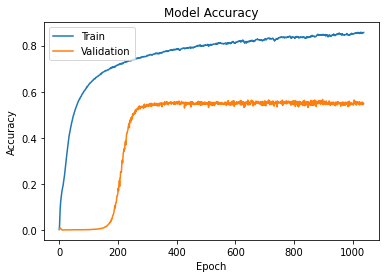

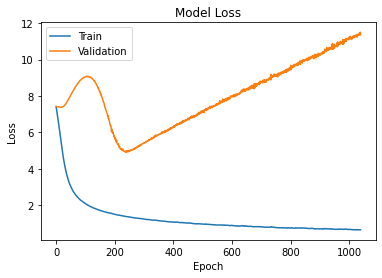

In [69]:
# Plot training and validation accuracy values
plt.plot(ranking_history['accuracy'])
plt.plot(ranking_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(ranking_history['loss'])
plt.plot(ranking_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [70]:
sample_rank_df = example_ranking_df.sample(48896)
user_rank_vecs, movie_rank_vecs = modified_ranking_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_rank_df['search']),
        k.preprocessing.sequence.pad_sequences(sample_rank_df['candidates']),
        k.preprocessing.sequence.pad_sequences(sample_rank_df['positives']),
        k.preprocessing.sequence.pad_sequences(sample_rank_df['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_rank_df['user_data']),
])

top_k = 5
movie_rank_vecs = np.array([movie_rank_vecs[i, :].argsort()[-top_k:] for i in range(len(movie_rank_vecs))]) - 1
ranking_kdt = KDTree(user_rank_vecs, metric='euclidean')

ranking_dict = {}
for user_id in unique_ids:
  sample_user_df_rank = example_ranking_df.loc[examples_df['user_id'] == user_id]
  ex_user_vecs, _ = modified_ranking_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_user_df_rank['search']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_rank['candidates']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_rank['positives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_rank['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_rank['user_data']),
])
  if np.isnan(ex_user_vecs).any() or np.isinf(ex_user_vecs).any():
      # Handle NaN, infinite or too large values in ex_user_vecs
      # You can choose to skip this user or replace NaN/infinite values with a default value
      continue
  ex_dist, ex_movie_vec_ids = ranking_kdt.query(ex_user_vecs,6)
  candidates_rank = set(filter(lambda x: x > 0, movie_vecs[ex_movie_vec_ids.squeeze()].flatten()))
  my_candidates_list =  list(example_ranking_df[example_ranking_df["user_id"]==user_id]["candidates"].head(1))[0]
  candidates_rank_union = set(my_candidates_list).intersection(list(candidates_rank))
  candidates_rank_df = df_items.iloc[list(candidates_rank_union)]
  ranking_dict[user_id] = list(candidates_rank_union)

1/1 [==============================] - 0s 35ms/step


In [71]:
for key, value in ranking_dict.items():
    if len(value) > 5: # top 5 Recommendations
        ranking_dict[key] = value[:5]

## Evaluation

In [72]:
# Convert the timestamp to a datetime object
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

# Create the interactions dataframe
interactions_df = df_ratings[['user_id', 'item_id', 'rating', 'timestamp']]
interactions_df['event_type'] = 'watch'

# Print the first few rows of the interactions dataframe
print(interactions_df.head())

   user_id  item_id  rating           timestamp event_type
0      195      241     3.0 1997-12-04 15:55:49      watch
1      185      301     3.0 1998-04-04 19:22:22      watch
2       21      376     1.0 1997-11-07 07:18:36      watch
3      243       50     2.0 1997-11-27 05:02:03      watch
4      165      345     1.0 1998-02-02 05:33:16      watch


In [73]:
def getPrecision(ranking_dict, interactions_df):
    user_precision_dict = {}
    for user_id, movie_ids in ranking_dict.items():
        TP = 0
        FP = 0 
        precision = 0
        num_watched = 0
        for movie_id in movie_ids:
            rating = interactions_df.loc[(interactions_df['user_id'] == user_id) & (interactions_df['item_id'] == movie_id), 'rating'].values
            if len(rating) > 0:
                num_watched += 1
                if rating[0] > 2: # like
                    TP += 1
                else:
                    FP += 1 # dislike
        if (TP + FP) > 0:
            precision = TP / (TP + FP)
        user_precision_dict[user_id] = {'precision': precision, 'num_watched_from_ranking': num_watched}
    return user_precision_dict

In [74]:
getPrecision_dict =  getPrecision(ranking_dict,interactions_df)

In [75]:
user_items_dict = interactions_df.groupby('user_id')['item_id'].agg(list).to_dict()

In [76]:
# Iterate over dictionaries and add new key-value pairs
for user_id, user_dict in user_items_dict.items():
    num_watched_total = len(user_dict)
    if user_id in getPrecision_dict:
      getPrecision_dict[user_id].update({"num_watched_total":num_watched_total})

In [77]:
w1 = 0.6   # weight for num_watched_from_ranking
w2 = 0.4   # weight for num_watched_total

# compute weighted average
precision_new = w1 * getPrecision_dict[0]['precision'] + w2 * getPrecision_dict[0]['num_watched_from_ranking'] / getPrecision_dict[0]['num_watched_total']

# update dictionary with new precision value
getPrecision_dict[0]['precision'] = precision_new

# print updated dictionary
print(getPrecision_dict)


{136: {'precision': 1.0, 'num_watched_from_ranking': 1, 'num_watched_total': 47}, 62: {'precision': 0.5, 'num_watched_from_ranking': 2, 'num_watched_total': 93}, 578: {'precision': 1.0, 'num_watched_from_ranking': 1, 'num_watched_total': 74}, 78: {'precision': 1.0, 'num_watched_from_ranking': 1, 'num_watched_total': 55}, 261: {'precision': 1.0, 'num_watched_from_ranking': 2, 'num_watched_total': 160}, 325: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 187}, 725: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 24}, 222: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 105}, 14: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 104}, 234: {'precision': 1.0, 'num_watched_from_ranking': 1, 'num_watched_total': 94}, 889: {'precision': 1.0, 'num_watched_from_ranking': 2, 'num_watched_total': 119}, 304: {'precision': 1.0, 'num_watched_from_ranking': 1, 'num_watched_total': 222}, 101: {'precision': 0.25, 'num_wa

In [78]:
sorted_dict = dict(sorted(getPrecision_dict.items(), key=lambda x: x[1]['num_watched_from_ranking'], reverse=True))

In [79]:
result_dict = {k: v for k, v in sorted_dict.items() if v['num_watched_from_ranking'] > 0}

In [80]:
precision_list = [item['precision'] for item in result_dict.values()]
avg_precision =  __builtins__.sum(precision_list) / len(precision_list)

print(avg_precision)

0.8840876514876999


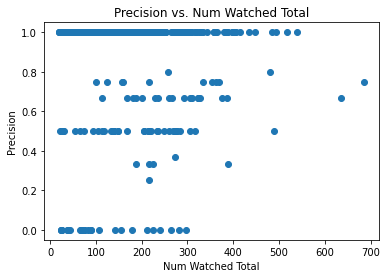

In [81]:
# Get precision and num_watched_total values
precision_list = [item['precision'] for item in result_dict.values()]
num_watched_total_list = [item['num_watched_total'] for item in result_dict.values()]

# Create scatter plot
plt.scatter(num_watched_total_list, precision_list)
plt.xlabel('Num Watched Total')
plt.ylabel('Precision')
plt.title('Precision vs. Num Watched Total')

# Show plot
plt.show()

## Popularity model

In [82]:
movie_pop_df = pd.DataFrame({'movie_id': df_items.index})
movie_pop_df.insert(1, 'avg_pop', None)
movie_pop_df.insert(2, 'count_rating', None)
movie_pop_df.insert(3, 'weighted_rating', None)

In [83]:
# First, we group interactions_df by movie_id and calculate the mean and count of ratings for each movie.
movie_ratings = interactions_df.groupby('item_id')['rating'].agg(['mean', 'count'])

# Next, we create the pop_dict dictionary by iterating over each movie in movie_pop_df
# and looking up its corresponding mean and count of ratings in the movie_ratings DataFrame.
pop_dict = {}
for movie_id in movie_pop_df['movie_id']:
    if movie_id in movie_ratings.index:
        # If this movie has ratings, add it to the pop_dict dictionary with its mean and count of ratings.
        mean_rating = movie_ratings.loc[movie_id, 'mean']
        rating_count = movie_ratings.loc[movie_id, 'count']
        pop_dict[movie_id] = (mean_rating, rating_count)
    else:
        # If this movie has no ratings, add it to the pop_dict dictionary with a default value of (0, 0).
        pop_dict[movie_id] = (0, 0)
# Loop over each movie_id in pop_dict and update the corresponding rows in movie_pop_df.
for movie_id, (mean_rating, rating_count) in pop_dict.items():
    movie_pop_df.loc[movie_pop_df['movie_id'] == movie_id, 'avg_pop'] = mean_rating
    movie_pop_df.loc[movie_pop_df['movie_id'] == movie_id, 'count_rating'] = rating_count
# Calculate the total count of ratings across all movies
total_count = movie_pop_df['count_rating'].sum()

# Calculate the weighted rating for each movie
weighted_ratings = movie_pop_df['avg_pop'] + ((movie_pop_df['count_rating'] / total_count) * 180)

# Add the new column to the DataFrame
movie_pop_df['weighted_rating'] = weighted_ratings
movie_pop_df.sort_values(by='weighted_rating', ascending=False, inplace=True)
# Get unique user IDs from the interactions DataFrame
user_ids = interactions_df['user_id'].unique()

# Create a new DataFrame with the user IDs
user_pop_df = pd.DataFrame({'user_id': user_ids})

In [84]:
user_pop_df.insert(1, 'window_watch', None)
user_pop_df.insert(2, 'top_pop', None)
user_pop_df.insert(3, 'movie_rec', None)
user_pop_df.insert(4, 'window_check', None)
user_pop_df.insert(5, 'precision', None)

In [85]:
# Define a function to extract the window watch and window check lists for a given user ID
def get_window_lists(user_id):
    # Filter the windows_df DataFrame to get the rows with the specified user ID
    user_windows = windows_df[windows_df['user_id'] == user_id]
    # Extract the window watch and window check lists for the user
    window_watch = user_windows['movie_ids'].iloc[0]
    window_check = user_windows['movie_ids'].iloc[1]
    # Return the lists as a tuple
    return (window_watch, window_check)

# Use the apply() method to apply the get_window_lists() function to each row of the user_pop_df DataFrame
user_pop_df[['window_watch', 'window_check']] = user_pop_df['user_id'].apply(get_window_lists).tolist()

# Sort the movie_pop_df DataFrame by weighted_rating in descending order
movie_pop_df = movie_pop_df.sort_values('weighted_rating', ascending=False)

# Get the list of movie IDs sorted by weighted_rating
sorted_movie_ids = movie_pop_df['movie_id'].tolist()

for index, row in user_pop_df.iterrows():
    user_pop_df.at[index, 'top_pop'] = sorted_movie_ids[:5]


In [86]:
user_dict = {}

# Iterate over each row in interactions_df
for index, row in interactions_df.iterrows():
    # Get the user ID and movie ID for the current row
    user_id = row['user_id']
    movie_id = row['item_id']
    
    # Check if the user ID is already in the dictionary
    if user_id in user_dict:
        # If the user ID is already in the dictionary, append the movie ID to the list
        user_dict[user_id].append(movie_id)
    else:
        # If the user ID is not yet in the dictionary, create a new list with the movie ID and add it to the dictionary
        user_dict[user_id] = [movie_id]

In [87]:
user_dict_up  = {}
for user_id, movie_list in user_dict.items():
    # Get the movie ID list from user_dict for the current user ID, excluding the movies in window_watch
    window_watch = user_pop_df[user_pop_df['user_id'] == user_id]['window_watch'].iloc[0]
    movie_list = [movie_id for movie_id in movie_list if movie_id not in window_watch]
    user_dict_up[user_id] = movie_list 

# function to update window_check column based on user_id
def update_window(row):
    user_id = row["user_id"]
    if user_id in user_dict_up:
        window = user_dict_up[user_id]
        return list(window)
    else:
        return ""

# apply function to update rank column
user_pop_df["window_check"] = user_pop_df.apply(update_window, axis=1)


In [88]:
# Create an empty dictionary to store the results
precision_pop_dict = {}

# Loop through the rows of user_pop_df and populate the dictionary
for index, row in user_pop_df.iterrows():
    user_id = row['user_id']
    movie_rec = row['top_pop']
        
    # Append the movie_rec value to the list for this user_id
    precision_pop_dict[user_id] = movie_rec


In [89]:
def getPrecisionPop(ranking_dict,interactions_df):
  user_precision_dict = {}
  for user_id, movie_ids in ranking_dict.items():
      TP = 0
      FP = 0 
      Precision = 0
      for movie_id in movie_ids:
          rating = interactions_df.loc[(interactions_df['user_id'] == user_id) & (interactions_df['item_id'] == movie_id), 'rating'].values
          if len(rating) > 0:
            if rating[0] > 2: # like
              TP += 1
            else:
              FP += 1 # dislike
      if (TP + FP) > 0:
        Precision = TP / (TP + FP)
      user_precision_dict[user_id] = Precision
  return user_precision_dict

In [90]:
dict_p = getPrecisionPop(precision_pop_dict,interactions_df)
# function to update window_check column based on user_id
def update_precision(row):
    user_id = row["user_id"]
    if user_id in dict_p:
        precision = dict_p[user_id]
        return precision
    else:
        return ""

# apply function to update rank column
user_pop_df["precision"] = user_pop_df.apply(update_precision, axis=1)

In [91]:
user_pop_df

,user_id,window_watch,top_pop,movie_rec,window_check,precision
0,195,"[268, 241, 285, 305, 339, 1021, 250, 256, 1006...","[49, 99, 126, 173, 1292]",None,"[392, 654, 66, 237, 662, 110, 579, 24, 93, 691...",0.000000
1,185,"[299, 287, 321, 290, 590, 297, 741, 120, 99, 9...","[49, 99, 126, 173, 1292]",None,"[301, 565, 249, 147, 262, 469, 280, 384, 587, ...",1.000000
2,21,"[257, 293, 687, 682, 999, 185, 172, 152, 153, ...","[49, 99, 126, 173, 1292]",None,"[376, 375, 127, 79, 240, 509, 78, 790, 510, 22...",1.000000
3,243,"[267, 293, 323, 300, 885, 309, 257, 771, 855, ...","[49, 99, 126, 173, 1292]",None,"[50, 814, 755, 672, 185, 264, 16, 380, 706, 54...",1.000000
4,165,"[314, 312, 287, 346, 285, 257, 293, 345, 750, ...","[49, 99, 126, 173, 1292]",None,"[342, 893, 242, 687]",0.000000
...,...,...,...,...,...,...
938,938,"[265, 325, 688, 889, 679, 257, 8, 126, 256, 27...","[49, 99, 126, 173, 1292]",None,"[930, 105, 1053, 475, 408, 120, 1022, 817, 933...",1.000000
939,935,"[257, 271, 312, 267, 268, 332, 903, 326, 345, ...","[49, 99, 126, 173, 1292]",None,"[1257, 817, 284, 105, 280, 951, 297, 110, 235,...",1.000000
940,929,"[285, 287, 244, 689, 49, 99, 0, 274, 236, 281,...","[49, 99, 126, 173, 1292]",None,"[120, 147, 7, 650, 762, 282, 268, 404, 152, 12...",0.666667
941,919,"[301, 312, 310, 271, 345, 287, 309, 331, 349, ...","[49, 99, 126, 173, 1292]",None,"[346, 330, 299, 681, 327, 291, 298, 267, 244, ...",0.000000


In [92]:
# Compute the average Precision
avg_precision = np.mean(list(dict_p.values()))

# Print the result
print(f"The average Precision is: {avg_precision:.2f}")

The average Precision is: 0.74


In [93]:
# group the DataFrame by user ID and calculate the average percentage
user_percentages = user_pop_df.groupby('user_id')['precision'].mean().reset_index()

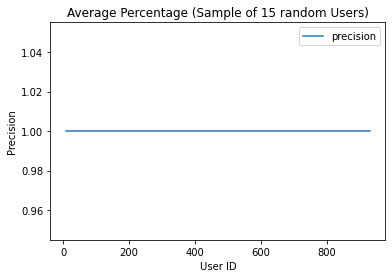

In [94]:
# select a random sample of 15 users
sample_users = np.random.choice(user_percentages['user_id'], size=15, replace=False)
sample_df = user_percentages.loc[user_percentages['user_id'].isin(sample_users)]

# plot the percentage values for the sample users
sample_df.plot(x='user_id', y='precision', kind='line')

# add axis labels and a title
plt.xlabel('User ID')
plt.ylabel('Precision')
plt.title('Average Percentage (Sample of 15 random Users)')

# display the plot
plt.show()

In [95]:
# define the percentage range boundaries
range_boundaries = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0])
# use pandas.cut to divide the percentages into ranges
user_percentages['range'] = pd.cut(user_percentages['precision'], bins=range_boundaries)
# count the number of users in each percentage range
range_counts = user_percentages['range'].value_counts().sort_index()

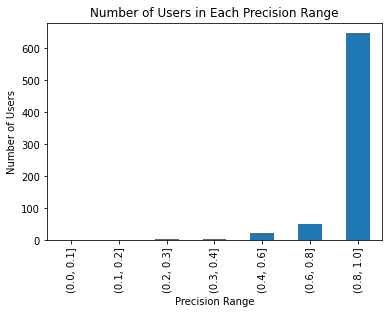

In [96]:
# create a bar chart of the number of users in each percentage range
range_counts.plot(kind='bar')

# add axis labels and a title
plt.xlabel('Precision Range')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Precision Range')

# display the plot
plt.show()

In [97]:
# create an empty dictionary to store the results
result_list = []

# loop over the rows of the DataFrame
for index, row in user_pop_df.iterrows():
    # extract the user_id, watch, and percentage values
    user_id = row['user_id']
    watch = row['window_check']
    percentage = row['precision']
    
    # add a tuple of the watch and percentage values to the dictionary
    result_list.append((watch, percentage))

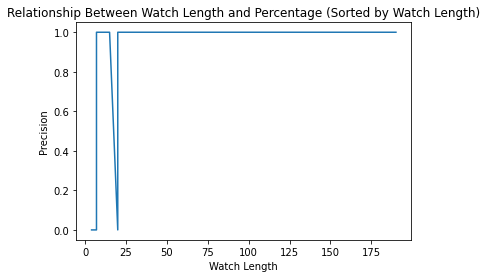

In [98]:
# randomly sample 15 tuples from result_list
sample = random.sample(result_list, 20)

# sort the sample by watch length
sorted_list = sorted(sample, key=lambda x: len(x[0]))

# extract the watch lengths and percentage values from sorted_list
watch_lengths = [len(t[0]) for t in sorted_list]
percentages = [t[1] for t in sorted_list]

# create a line graph of the data
plt.plot(watch_lengths, percentages)

# add axis labels and a title
plt.xlabel('Watch Length')
plt.ylabel('Precision')
plt.title('Relationship Between Watch Length and Percentage (Sorted by Watch Length)')

# display the plot
plt.show()

## Imporovment Suggestion 

In [99]:
def Ranking_with_Attention(n_items, n_genres, n_user_data, embedding_dim, user_dim):
    # Define layers
    genres_ids_input = k.Input(shape=(None, ), name='genres_ids')
    candidates_ids_input = k.Input(shape=(None, ), name='candidates_ids')
    positive_ids_input = k.Input(shape=(None, ), name='positive_ids')
    negative_ids_input = k.Input(shape=(None, ), name='negative_ids')
    user_data_input = k.Input(shape=(n_user_data), name='user_data_vec')

    genres_embedding_layer = k.layers.Embedding(input_dim=n_genres, output_dim=embedding_dim, 
                                                mask_zero=True, trainable=True, name='genres_embeddings')
    labels_embedding_layer = k.layers.Embedding(input_dim=n_items, output_dim=embedding_dim,
                                                mask_zero=True, trainable=True, name='labels_embeddings')
    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    dense_1 = k.layers.Dense(units=embedding_dim, name='dense_1')
    dense_2 = k.layers.Dense(units=embedding_dim, name='dense_2')
    dense_3 = k.layers.Dense(units=user_dim, name='dense_3')

    l2_norm_1 = L2NormLayer(name='l2_norm_1')
    dense_output = k.layers.Dense(n_items, activation=tf.nn.softmax, name='dense_output')

    # Feature extraction
    genres_embeddings = genres_embedding_layer(genres_ids_input)
    l2_norm_genres = l2_norm_1(genres_embeddings)
    avg_genres = avg_embeddings(l2_norm_genres)

    labels_candidates_embeddings = labels_embedding_layer(candidates_ids_input)
    l2_norm_candidates = l2_norm_1(labels_candidates_embeddings)
    avg_candidates = avg_embeddings(l2_norm_candidates)

    labels_positive_embeddings = labels_embedding_layer(positive_ids_input)
    l2_norm_positive = l2_norm_1(labels_positive_embeddings)
    avg_positive = avg_embeddings(l2_norm_positive)

    labels_negative_embeddings = labels_embedding_layer(negative_ids_input)
    l2_norm_negative = l2_norm_1(labels_negative_embeddings)
    avg_negative = avg_embeddings(l2_norm_negative)

    concat_inputs = tf.keras.layers.Concatenate(axis=1)([
        avg_genres, avg_positive, avg_negative, user_data_input, avg_candidates
    ])

    # Attention layers
    attention_layer_1 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='attention_layer_1')
    attention_layer_2 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='attention_layer_2')
    attention_layer_3 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='attention_layer_3')
    dense_attention = k.layers.Dense(units=embedding_dim, name='dense_attention')

    # Self-attention layers
    self_attention_layer_1 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='self_attention_layer_1')
    self_attention_layer_2 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='self_attention_layer_2')
    self_attention_layer_3 = k.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim, name='self_attention_layer_3')
    dense_self_attention = k.layers.Dense(units=embedding_dim, name='dense_self_attention')

    # Dense Layers
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    dense_1_attention = dense_attention(dense_1_batch_norm)
    dense_1_attention_relu = tf.keras.layers.ReLU(name='dense_1_attention_relu')(dense_1_attention)
    dense_1_attention_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_attention_batch_norm')(dense_1_attention_relu)

    dense_2_features = dense_2(dense_1_attention_batch_norm)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    dense_2_self_attention = dense_self_attention(dense_2_batch_norm)
    dense_2_self_attention_relu = tf.keras.layers.ReLU(name='dense_2_self_attention_relu')(dense_2_self_attention)
    dense_2_self_attention_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_self_attention_batch_norm')(dense_2_self_attention_relu)

    dense_3_features = dense_3(dense_2_self_attention_batch_norm)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='user_vec')(dense_3_relu)
    outputs = dense_output(dense_3_batch_norm)
    
    model = tf.keras.models.Model(
        inputs=[genres_ids_input,candidates_ids_input, positive_ids_input, negative_ids_input, user_data_input],
        outputs=[outputs]
    )
    
    return model

In [100]:
def find_best_params(EMBEDDING_DIMS_LIST, LEARNING_RATE_LIST, DENSE_UNITS_LIST, USER_DIM_LIST, EPOCHE_LIST):
    # Define constants
    BATCH_SIZE = 256
    
    # Create parameter grid
    param_grid = ParameterGrid({
        'EMBEDDING_DIMS': EMBEDDING_DIMS_LIST,
        'LEARNING_RATE': LEARNING_RATE_LIST,
        'DENSE_UNITS': DENSE_UNITS_LIST,
        'USER_DIM': USER_DIM_LIST,
        'EPOCHS': EPOCHE_LIST
    })
    
    # Train model for each combination of parameters
    results = []
    for params in param_grid:
        # Compile Model
        ranking_with_attention_model = Ranking_with_Attention(
            n_items=df_items.index.astype(int).max()+2, 
            n_genres=len(genres) + 1, 
            n_user_data=len(examples_df.iloc[0]['user_data']), 
            embedding_dim=params['EMBEDDING_DIMS'],
            user_dim=params['USER_DIM']
        )
        optimiser = k.optimizers.Adam(learning_rate=params['LEARNING_RATE'])
        ranking_with_attention_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train model
        history = ranking_with_attention_model.fit(
            x=[
              k.preprocessing.sequence.pad_sequences(train_df['search']),
              k.preprocessing.sequence.pad_sequences(train_df['candidates']),
              k.preprocessing.sequence.pad_sequences(train_df['positives']),
              k.preprocessing.sequence.pad_sequences(train_df['negatives']),
              k.preprocessing.sequence.pad_sequences(train_df['user_data']),
               ], 
            y=train_df['label'].values, 
            batch_size=BATCH_SIZE, 
            epochs=params['EPOCHS'], 
            validation_data=([
                k.preprocessing.sequence.pad_sequences(val_df['search']),
                k.preprocessing.sequence.pad_sequences(val_df['candidates']),
                k.preprocessing.sequence.pad_sequences(val_df['positives']),
                k.preprocessing.sequence.pad_sequences(val_df['negatives']),
                k.preprocessing.sequence.pad_sequences(val_df['user_data']),
            ], val_df['label'].values),
            verbose=1
        )
        
        # Evaluate model
        loss, accuracy = ranking_with_attention_model.evaluate([
                k.preprocessing.sequence.pad_sequences(test_df['search']),
                k.preprocessing.sequence.pad_sequences(test_df['candidates']),
                k.preprocessing.sequence.pad_sequences(test_df['positives']),
                k.preprocessing.sequence.pad_sequences(test_df['negatives']),
                k.preprocessing.sequence.pad_sequences(test_df['user_data']),
            ], test_df['label'].values,
            batch_size=BATCH_SIZE, 
            verbose=1
        )
        
        # Save results
        results.append({
            'EMBEDDING_DIMS': params['EMBEDDING_DIMS'],
            'LEARNING_RATE': params['LEARNING_RATE'],
            'DENSE_UNITS': params['DENSE_UNITS'],
            'USER_DIM': params['USER_DIM'],
            'EPOCHS': params['EPOCHS'],
            'loss': loss,
            'accuracy': accuracy,
            'history': history
        })
        
        # Print progress
        print(f"Finished training model with params: {params}")
        
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Return DataFrame sorted by accuracy
    return results_df.sort_values(by='accuracy', ascending=False)


In [101]:
#results_ranking_with_att_df = find_best_params(EMBEDDING_DIMS_LIST, LEARNING_RATE_LIST, DENSE_UNITS_LIST, USER_DIM_LIST, EPOCHE_LIST)

In [102]:
results_ranking_with_att_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/recsys/params_result_for_paper_alg_with_at.csv')

In [119]:
results_ranking_with_att_df

,embedding_dims,learning_rate,dense_units,user_dim,epochs,precision,accuracy,loss
0,16,0.0001,32,32,10,0.844298,0.578514,1.436470
1,16,0.0001,32,32,150,0.759058,0.356226,2.498574
2,16,0.0001,32,32,250,0.783416,0.424820,2.369298
3,16,0.0001,32,64,10,0.819905,0.409502,4.439794
4,16,0.0001,32,64,150,0.794838,0.499657,2.689675
...,...,...,...,...,...,...,...,...
427,1024,0.0030,128,64,150,0.756904,0.554672,3.497598
428,1024,0.0030,128,64,250,0.826926,0.496434,2.296081
429,1024,0.0030,128,128,10,0.719578,0.499346,4.006212
430,1024,0.0030,128,128,150,0.735398,0.577501,1.741648


In [103]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
USER_DIM=32
LEARNING_RATE = 0.001
# Compile Model
ranking_with_attention_model = Ranking_with_Attention(
    n_items=df_items.index.astype(int).max()+2, 
    n_genres=len(genres) + 1, 
    n_user_data=len(examples_df.iloc[0]['user_data']), 
    embedding_dim=EMBEDDING_DIMS,
    user_dim=USER_DIM
)
optimiser = k.optimizers.Adam(learning_rate=LEARNING_RATE)
ranking_with_attention_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modified_ranking_with_attention_model = k.Model(inputs=ranking_with_attention_model.input, outputs=[ranking_with_attention_model.get_layer('user_vec').output, *ranking_with_attention_model.outputs])

In [104]:
"""
ranking_with_attention_model_history = ranking_with_attention_model.fit(
    x=[
        k.preprocessing.sequence.pad_sequences(rank_train_df['search']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['candidates']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['positives']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['negatives']),
        k.preprocessing.sequence.pad_sequences(rank_train_df['user_data']),
    ], 
    y=rank_train_df['label'].values,
    validation_data=([
        k.preprocessing.sequence.pad_sequences(rank_val_df['search']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['candidates']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['positives']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['negatives']),
        k.preprocessing.sequence.pad_sequences(rank_val_df['user_data']),
    ], rank_val_df['label'].values),
    callbacks=[
        k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
        k.callbacks.EarlyStopping(patience=800, restore_best_weights=True)
    ], 
    steps_per_epoch=1, 
    epochs=1000, 
    verbose=1,
)
"""


'\nranking_with_attention_model_history = ranking_with_attention_model.fit(\n    x=[\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'candidates\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(rank_train_df[\'user_data\']),\n    ], \n    y=rank_train_df[\'label\'].values,\n    validation_data=([\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'search\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'candidates\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'positives\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'negatives\']),\n        k.preprocessing.sequence.pad_sequences(rank_val_df[\'user_data\']),\n    ], rank_val_df[\'label\'].values),\n    callbacks=[\n        

In [105]:
ranking_with_attention_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 genres_ids (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 positive_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 negative_ids (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 candidates_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                            

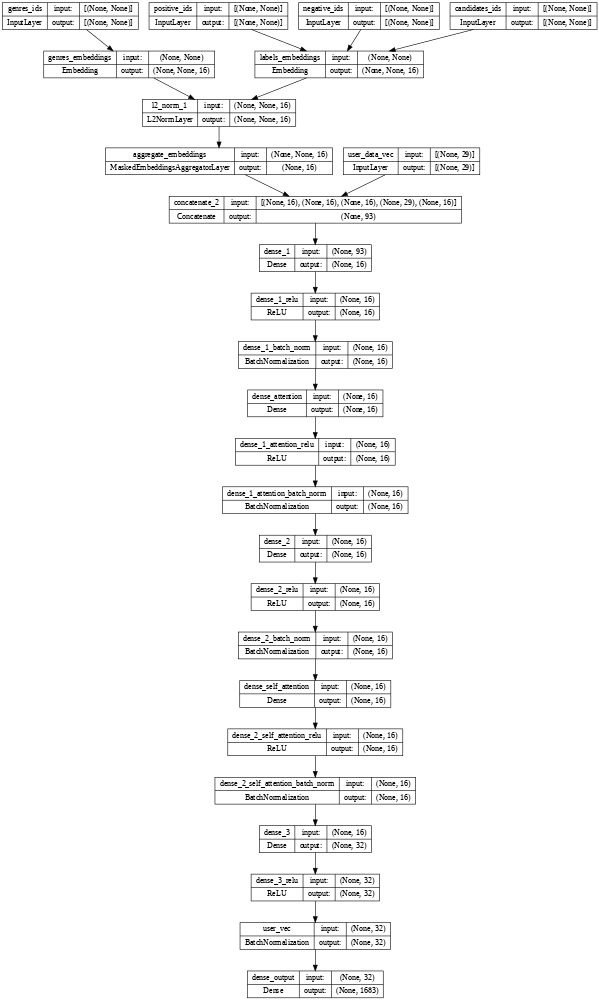

In [106]:
tf.keras.utils.plot_model(ranking_with_attention_model, show_shapes=True, show_layer_names=True,dpi=42)

In [107]:
"""
ranking_with_attention_model.save('ranking_with_attention_model.h5')
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_with_attention_model_history.pickle', 'wb') as f:
    pickle.dump(ranking_with_attention_model_history.history, f)
"""

"\nranking_with_attention_model.save('ranking_with_attention_model.h5')\nwith open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_with_attention_model_history.pickle', 'wb') as f:\n    pickle.dump(ranking_with_attention_model_history.history, f)\n"

In [108]:
ranking_with_attention_model = load_model('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_with_attention_model.h5', custom_objects={'L2NormLayer': L2NormLayer,'MaskedEmbeddingsAggregatorLayer':MaskedEmbeddingsAggregatorLayer})
with open('/content/drive/MyDrive/Colab_Notebooks/recsys/ranking_with_attention_model_history.pickle', 'rb') as f:
    ranking_with_attention_model_history = pickle.load(f)

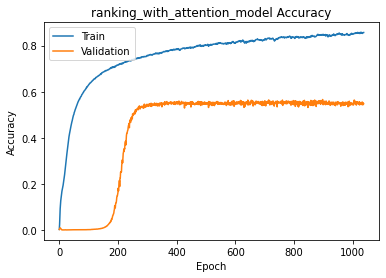

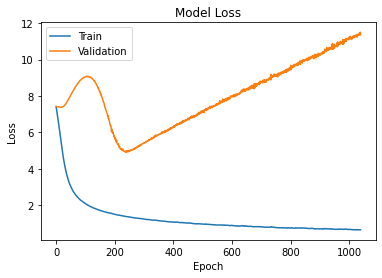

In [109]:
# Plot training and validation accuracy values
plt.plot(ranking_history['accuracy'])
plt.plot(ranking_history['val_accuracy'])
plt.title('ranking_with_attention_model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(ranking_history['loss'])
plt.plot(ranking_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [110]:
sample_attention_df = example_ranking_df.sample(48896)
user_attention_vecs, movie_attention_vecs = modified_ranking_with_attention_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_attention_df['search']),
        k.preprocessing.sequence.pad_sequences(sample_attention_df['candidates']),
        k.preprocessing.sequence.pad_sequences(sample_attention_df['positives']),
        k.preprocessing.sequence.pad_sequences(sample_attention_df['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_attention_df['user_data']),
])

top_k = 5
movie_attention_vecs = np.array([movie_rank_vecs[i, :].argsort()[-top_k:] for i in range(len(movie_rank_vecs))]) - 1
ranking_attention_kdt = KDTree(user_attention_vecs, metric='euclidean')

attention_dict = {}
for user_id in unique_ids:
  sample_user_df_attention = example_ranking_df.loc[examples_df['user_id'] == user_id]
  ex_user_vecs, _ = modified_ranking_with_attention_model.predict(x=[
        k.preprocessing.sequence.pad_sequences(sample_user_df_attention['search']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_attention['candidates']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_attention['positives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_attention['negatives']),
        k.preprocessing.sequence.pad_sequences(sample_user_df_attention['user_data']),
])
  if np.isnan(ex_user_vecs).any() or np.isinf(ex_user_vecs).any():
      # Handle NaN, infinite or too large values in ex_user_vecs
      # You can choose to skip this user or replace NaN/infinite values with a default value
      continue
  ex_dist, ex_movie_vec_ids = ranking_attention_kdt.query(ex_user_vecs,6)
  candidates_rank = set(filter(lambda x: x > 0, movie_attention_vecs[ex_movie_vec_ids.squeeze()].flatten()))
  my_candidates_attention_list =  list(example_ranking_df[example_ranking_df["user_id"]==user_id]["candidates"].head(1))[0]
  candidates_attention_rank_union = set(my_candidates_attention_list).intersection(list(candidates_rank))
  candidates_rank_df = df_items.iloc[list(candidates_attention_rank_union)]
  attention_dict[user_id] = list(candidates_attention_rank_union)

1/1 [==============================] - 0s 23ms/step


In [111]:
for key, value in attention_dict.items():
    if len(value) > 5: # top 5 Recommendations
        attention_dict[key] = value[:5]

In [112]:
getPrecision_attention_dict =  getPrecision(attention_dict,interactions_df)

In [113]:
# Iterate over dictionaries and add new key-value pairs
for user_id, user_dict in user_items_dict.items():
    num_watched_total = len(user_dict)
    if user_id in getPrecision_attention_dict:
      getPrecision_attention_dict[user_id].update({"num_watched_total":num_watched_total})

In [114]:
w1 = 0.6   # weight for num_watched_from_ranking
w2 = 0.4   # weight for num_watched_total

# compute weighted average
precision_new = w1 * getPrecision_attention_dict[0]['precision'] + w2 * getPrecision_attention_dict[0]['num_watched_from_ranking'] / getPrecision_attention_dict[0]['num_watched_total']

# update dictionary with new precision value
getPrecision_attention_dict[0]['precision'] = precision_new

# print updated dictionary
print(getPrecision_attention_dict)


{136: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 47}, 62: {'precision': 0.0, 'num_watched_from_ranking': 1, 'num_watched_total': 93}, 578: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 74}, 78: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 55}, 261: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 160}, 325: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 187}, 725: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 24}, 222: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 105}, 14: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 104}, 234: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 94}, 889: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 119}, 304: {'precision': 0, 'num_watched_from_ranking': 0, 'num_watched_total': 222}, 101: {'precision': 0.0, 'num_watched_from_rank

In [115]:
sorted_attention_dict = dict(sorted(getPrecision_attention_dict.items(), key=lambda x: x[1]['num_watched_from_ranking'], reverse=True))

In [116]:
result_attention_dict = {k: v for k, v in sorted_attention_dict.items() if v['num_watched_from_ranking'] > 0}

In [121]:
precision_attention_list = [item['precision'] for item in result_attention_dict.values()]
avg_attention_precision =  __builtins__.sum(precision_attention_list) / len(precision_attention_list)

print(avg_attention_precision)

0.8829567127397409


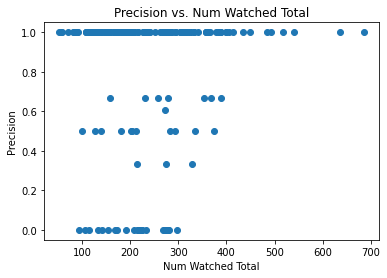

In [118]:
# Get precision and num_watched_total values
precision_list = [item['precision'] for item in result_attention_dict.values()]
num_watched_total_list = [item['num_watched_total'] for item in result_attention_dict.values()]

# Create scatter plot
plt.scatter(num_watched_total_list, precision_list)
plt.xlabel('Num Watched Total')
plt.ylabel('Precision')
plt.title('Precision vs. Num Watched Total')

# Show plot
plt.show()